# Setup and Imports

In [31]:
import importlib.util

if importlib.util.find_spec('pandas') is None:
    %pip install pandas

if importlib.util.find_spec('numpy') is None:
    %pip install numpy

if importlib.util.find_spec('pydantic') is None:
    %pip install pydantic

if importlib.util.find_spec('sqlalchemy') is None:
    %pip install sqlalchemy

if importlib.util.find_spec('matplotlib') is None:
    %pip install matplotlib

if importlib.util.find_spec('seaborn') is None:
    %pip install seaborn
    
# Data manipulation
# Pandas is the go-to library for data manipulation in Python
# You can load data from many different formats (CSV, Excel, SQL, JSON, etc.) and query / manipulate / transform it easily

# NumPy is the foundational numerical computing library in Python
# NumPy is used heavily by Pandas and other libraries for efficient array operations and mathematical functions
# We won't use it much directly, but it's good to have available for advanced calculations if needed
import pandas as pd
import numpy as np

# Data validation
# Pydantic is a powerful library for data validation and settings management using Python type annotations
from pydantic import BaseModel, Field, ValidationError

# Database access
# SQLAlchemy is the most popular ORM (Object Relational Mapper) in Python
# It allows you to interact with databases using Python classes and objects instead of raw SQL queries
# However, it DOES support raw SQL queries as well
from sqlalchemy import create_engine, Column, Integer, String, Float, text
from sqlalchemy.orm import declarative_base, sessionmaker

# Data visualization
# Matplotlib is the foundational plotting library in Python
# Seaborn is built on top of Matplotlib and provides a higher-level interface for creating pretty things
import matplotlib.pyplot as plt
import seaborn as sns

# this makes the jupyter notebook prettier
from IPython.display import display


# Data Retrieval

In [32]:
from sqlalchemy import create_engine, Column, Integer, String, Float
from sqlalchemy.orm import declarative_base, sessionmaker
import pandas as pd
from IPython.display import display

# Base class
Base = declarative_base()

# ORM Model
class Product(Base):
    __tablename__ = 'products'
    id = Column(Integer, primary_key=True)
    name = Column(String)
    category = Column(String)
    price = Column(Float)

# In-memory SQLite database
engine = create_engine('sqlite:///:memory:')
Base.metadata.create_all(engine)

# Create session
Session = sessionmaker(bind=engine)
session = Session()

# Insert sample data
session.add_all([
    Product(name='Laptop', category='Electronics', price=1200.50),
    Product(name='Phone', category='Electronics', price=800.00),
    Product(name='Desk', category='Furniture', price=300.00),
    Product(name='Chair', category='Furniture', price=150.00)
])
session.commit()

# Insert with raw SQL
with engine.connect() as conn:
    conn.execute(text("""
        INSERT INTO products (name, category, price) VALUES
        ('Headphones', 'Electronics', 150.00),
        ('Monitor', 'Electronics', 400.00)
    """))
    conn.commit()

# Query data and convert to DataFrame (Ignore the dataframe stuff, we'll cover it later)
df = pd.DataFrame([p.__dict__ for p in session.query(Product).all()])
df = df.drop(columns='_sa_instance_state')  # Remove SQLAlchemy internal column
display(df)


,name,price,id,category
0,Laptop,1200.5,1,Electronics
1,Phone,800.0,2,Electronics
2,Desk,300.0,3,Furniture
3,Chair,150.0,4,Furniture
4,Headphones,150.0,5,Electronics
5,Monitor,400.0,6,Electronics


# Data Validation with Pydantic

In [ ]:
class ProductModel(BaseModel):
    id: int
    name: str
    category: str
    price: float = Field(gt=0)  # Must be greater than zero

validated_data = []
# df.to_dict(orient='records') converts each row to a dictionary. Kinda like a JSON object
# We are looping through this dictionary and validating each row against the ProductModel schema
for row in df.to_dict(orient='records'):
    try:
        validated_data.append(ProductModel(**row))
    except ValidationError as e:
        print(f"Validation error: {e}")

# Example of invalid data
# (The price is negative, which should trigger a validation error)
invalid_dict = {'id': 6, 'name': 'Invalid Product', 'category': 'Misc', 'price': -50.00}
try:
    invalid_product = ProductModel(**invalid_dict)
except ValidationError as e:
    print(f"Validation error: {e}")

# Convert back to DataFrame
# model_dump() converts the Pydantic model back to a dictionary (the JSON object)
# Just to show how this stuff connects together, we'll convert the validated data back to a DataFrame 
validated_df = pd.DataFrame([item.model_dump() for item in validated_data])
display(validated_df)


Validation error: 1 validation error for ProductModel
price
  Input should be greater than 0 [type=greater_than, input_value=-50.0, input_type=float]
    For further information visit https://errors.pydantic.dev/2.11/v/greater_than


,id,name,category,price
0,1,Laptop,Electronics,1200.5
1,2,Phone,Electronics,800.0
2,3,Desk,Furniture,300.0
3,4,Chair,Furniture,150.0
4,5,Headphones,Electronics,150.0
5,6,Monitor,Electronics,400.0


# Data Manipulation with Pandas & NumPy

In [ ]:
# Add a new column: price after tax (8%)
# Note, this is how EASY it is to use Pandas to manipulate data
# This will multiply all data in the 'price' column by 1.08 and create a new column called 'price_after_tax'
validated_df['price_after_tax'] = validated_df['price'] * 1.08

# Group by category and compute average price
# A lot of the syntax here is similar to SQL
# We are grouping by the 'category' column and computing the mean of the 'price_after_tax' column
category_summary = validated_df.groupby('category')['price_after_tax'].mean().reset_index()
display(category_summary)

# Use NumPy for advanced calculations
# I doubt we'll ever need this, but just in case we need to
# do some wild math, numpy is available
validated_df['price_zscore'] = np.round((validated_df['price'] - validated_df['price'].mean()) / validated_df['price'].std(), 2)
display(validated_df)


,category,price_after_tax
0,Electronics,688.635
1,Furniture,243.000


,id,name,category,price,price_after_tax,price_zscore
0,1,Laptop,Electronics,1200.5,1296.54,1.67
1,2,Phone,Electronics,800.0,864.00,0.72
2,3,Desk,Furniture,300.0,324.00,-0.48
3,4,Chair,Furniture,150.0,162.00,-0.84
4,5,Headphones,Electronics,150.0,162.00,-0.84
5,6,Monitor,Electronics,400.0,432.00,-0.24


# Visualization with Matplotlib & Seaborn

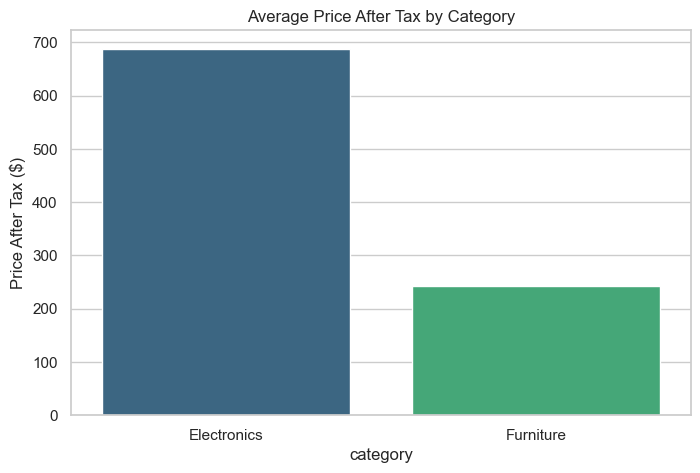

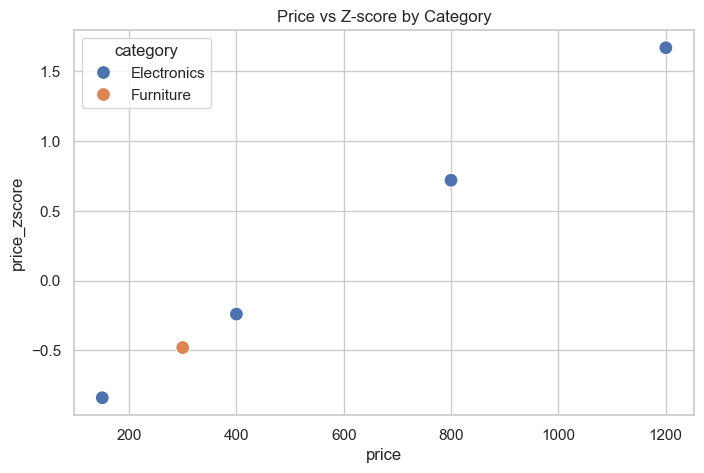

In [35]:
# MatPlotLib is the foundational plotting library in Python
# Seaborn is built on top of MatPlotLib and provides some simpler syntax

# Set Seaborn style
sns.set_theme(style='whitegrid')

# Bar plot: average price by category
plt.figure(figsize=(8,5))
sns.barplot(data=category_summary, x='category', y='price_after_tax', hue='category', legend=False, palette='viridis')
plt.title('Average Price After Tax by Category')
plt.ylabel('Price After Tax ($)')
plt.show()

# Scatter plot: price vs. z-score
plt.figure(figsize=(8,5))
sns.scatterplot(data=validated_df, x='price', y='price_zscore', hue='category', s=100)
plt.title('Price vs Z-score by Category')
plt.show()
